# Read all the hap.py vcfs and compute overlaps

## Read metadata

In [30]:
import vcf
import vcf.utils
import glob
import re
import pandas as pd
import upsetplot

In [31]:
paths = glob.glob("d50_variant_analysis/*/*vcf.gz")

In [32]:
names, kits, concs, replicates = zip(*[
    re.match(r".*/(([A-Za-z0-9]+)-(\d+ng)-(\d))\.vcf\.gz", path).groups()
    for path in paths
])

In [33]:
df = pd.DataFrame({'Name': names, 'Kit': kits, 'Conc': concs, 'Replicate': replicates, 'Path': paths})

In [34]:
df.head()

,Name,Kit,Conc,Replicate,Path
0,NEB-10ng-1,NEB,10ng,1,d50_variant_analysis/NEB-10ng-1_happy/NEB-10ng...
1,NEB-10ng-3,NEB,10ng,3,d50_variant_analysis/NEB-10ng-3_happy/NEB-10ng...
2,Quanta-100ng-2,Quanta,100ng,2,d50_variant_analysis/Quanta-100ng-2_happy/Quan...
3,Swift2S-100ng-4,Swift2S,100ng,4,d50_variant_analysis/Swift2S-100ng-4_happy/Swi...
4,Nextera-10ng-3,Nextera,10ng,3,d50_variant_analysis/Nextera-10ng-3_happy/Next...


### Only analyse 100 ng data

In [35]:
# af = analysis data frame
af = df[(df.Conc=='100ng')&(df.Kit!="Swiftlong")]

## Read VCF data

In [36]:
kits = list(set(af.Kit))[::-1]

In [47]:
kits_readers = [(row.Kit, vcf.Reader(filename=row.Path)) for _, row in af.iterrows()]
kits, readers = zip(*kits-readers)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [38]:
# Make a place to hold the counts
group_counts_idx = pd.MultiIndex.from_product([[True,False] for _ in kits], names=kits)
group_combinations = pd.Series(index=group_counts_idx, dtype='uint32')
intra_kit_consensus = {kitname: [0, 0, 0, 0, 0] for kitname in kits}

In [39]:
abort = 200000
num_all_call_not_tp = 0
num_tp = 0
for variants in vcf.utils.walk_together(*readers):
    if abort == 0:
        break
    else:
        abort -= 1
        if abort % 10000 == 0:
            print(abort, "variants remaining...")
    if not all(variants): # True variants should have entries in all samples
        continue
    if not variants[0].samples[0].data.BD:
        num_all_call_not_tp += 1
    else:
        num_tp += 1
    var_group_counts = [0] * len(kits)
    for vcall, irow in zip(variants, af.iterrows()):
        is_tp = vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ >= 5
        if is_tp:
            var_group_counts[kits.index(irow[1].Kit)] += 1
    if any(gc > 0 for gc in var_group_counts):
        for i, kit in enumerate(kits):
            intra_kit_consensus[kit][var_group_counts[i]] += 1
        combinations_index = tuple(x > 2 for x in var_group_counts)
        group_combinations[combinations_index] += 1
        #if combinations_index == [True]*6:
        #    print("ALL FOUND IT")
        #    break
print("True positives:", num_tp)
print("Called by all, but not TP:", num_all_call_not_tp)

True positives: 114136
Called by all, but not TP: 717


In [44]:
var_group_counts

[0, 0, 0, 0, 0]

In [45]:
group_combinations[tuple(combinations_index)]

51970

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fa62ae8e748>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fa62a507e48>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fa6287b9da0>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fa628774dd8>}

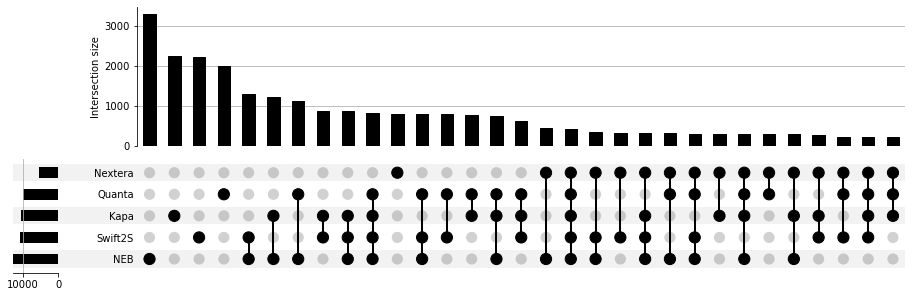

In [42]:
upsetplot.plot(group_combinations.drop(tuple([0]*len(kits))), sort_by='cardinality')

In [43]:
kits

['Swift2S', 'Quanta', 'NEB', 'Nextera', 'Kapa']